In [5]:
%config Completer.use_jedi = False

# IMPORTS

In [1]:
import math
import os
import sys
import pandas as pd
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from statannot import add_stat_annotation

pd.options.mode.chained_assignment = None  # default='warn'
import multiprocessing
import parmap
import numpy as np
import collections
from tqdm import tqdm
import pandarallel
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=20, progress_bar=True)
# tqdm.pandas()
from pprint import pprint
from scipy.stats import zscore
from scipy import stats

import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mc
from matplotlib.colors import LogNorm
import json
import matplotlib.ticker as mtick
from utils.utils import load_config_file

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/EXOTIC/src/config.yaml")
exotic_files = yaml

import matplotlib.font_manager as font_manager

font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


# EXOTIC file combined with BIOMART for ENS IDs

In [5]:
exotic_biomart = pd.read_parquet('/gstock/EXOTIC/data/EXOTIC/EXOTIC_corrected_biomart_for_QTL_corrected.parquet')
exotic_biomart['OK_join'] = exotic_biomart['OK'].apply(lambda r : ','.join(r))
exotic_biomart.symbol.nunique()

3854

In [43]:
exotic_biomart[['symbol', 'Gene_ID', 'HGNC_ID', 'Exon', 'Ratio_num', 'mRNA_nb', 'OK_bronze',
       'OK_silver', 'OK_gold', 'OK', 'Exon_start_GRCh37',
       'Exon_end_GRCh37', 'CHROM', 'Gene_start_GRCh38',
       'Gene_end_GRCh38',  'Gene_start_GRCh37',
       'Gene_end_GRCh37']].to_excel('/gstock/EXOTIC/data/EXOTIC/EXOTIC_above_thresholds.xlsx', index=False)

### all sQTLs

In [19]:
sqtlseeker_dir = '/gstock/biolo_datasets/QTL/sqlseeker-2/sQTLs.GTEx.V8.RSEM/'
sqtlseeker_listdir = sorted([d for d in os.listdir(sqtlseeker_dir) if 'parquet' not in d])

def mp_sqtl(tissue, l_df):
    sqtlseeker_tmp = pd.read_csv(sqtlseeker_dir + tissue + '/sqtls-0.05fdr.permuted.tsv.gz', compression='gzip', sep='\t')
    sqtlseeker_tmp['Tissue'] = tissue
    sqtlseeker_tmp['gene_id'] = sqtlseeker_tmp['geneId'].apply(lambda r: r.split('.')[0])
#     merge = pd.merge(merge_biomart, sqtlseeker_tmp, right_on='gene_id', left_on='Gene stable ID')
    l_df.append(sqtlseeker_tmp)


m = multiprocessing.Manager()
l_df = m.list()
# for tissue in sqtlseeker_listdir:
parmap.starmap(mp_sqtl, list(zip(sqtlseeker_listdir)), l_df, pm_pbar=True)

concat_df_sqtlseeker_dir_complete = pd.concat(list(l_df)).sort_values(by=['gene_id'])
concat_df_sqtlseeker_dir_complete

100%|██████████| 49/49 [00:01<00:00, 25.09it/s]


,geneId,variants.cis,LD,best.snp,best.nominal.pv,shape1,shape2,nb.perm,pv.emp.perm,pv.emp.beta,...,info,pv,F.svQTL,nb.perms.svQTL,pv.svQTL,fdr.svQTL,Tissue,gene_id,nb.perms,pv.emp
9,ENSG00000000003.14,16,0.453752,X_100625253_T_C_b38,0.000321,0.865772,3.945680,1000.0,0.002997,0.003219,...,"0,184,44,102",0.000887,2.130104,10100,0.121968,0.596560,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN
0,ENSG00000000003.14,16,0.453752,X_100625253_T_C_b38,0.000321,0.865772,3.945680,1000.0,0.002997,0.003219,...,"0,200,43,87",0.000321,4.318615,10100,0.014355,0.284923,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN
1,ENSG00000000003.14,16,0.453752,X_100625253_T_C_b38,0.000321,0.865772,3.945680,1000.0,0.002997,0.003219,...,"0,200,43,87",0.000321,4.318615,10100,0.014355,0.284923,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN
2,ENSG00000000003.14,16,0.453752,X_100625253_T_C_b38,0.000321,0.865772,3.945680,1000.0,0.002997,0.003219,...,"0,200,43,87",0.000321,4.318615,10100,0.014355,0.284923,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN
3,ENSG00000000003.14,16,0.453752,X_100625253_T_C_b38,0.000321,0.865772,3.945680,1000.0,0.002997,0.003219,...,"0,198,45,87",0.000364,3.465316,10100,0.032373,0.394363,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99941,ENSG00000284505.1,68,0.070537,8_142780034_T_G_b38,0.000001,0.858928,22.284342,1000.0,0.000999,0.000114,...,"0,177,299,85",0.000272,1.379009,10100,0.244332,0.682789,Skin - Sun Exposed (Lower leg),ENSG00000284505,NaN,NaN
88162,ENSG00000284505.1,63,0.073587,8_142763040_G_A_b38,0.000012,0.855260,20.774832,1000.0,0.000999,0.000890,...,"1,100,246,103",0.000143,3.393176,10100,0.032472,0.345412,Skin - Not Sun Exposed (Suprapubic),ENSG00000284505,NaN,NaN
88163,ENSG00000284505.1,63,0.073587,8_142763040_G_A_b38,0.000012,0.855260,20.774832,1000.0,0.000999,0.000890,...,"0,268,150,32",0.000165,1.847665,10100,0.160380,0.606330,Skin - Not Sun Exposed (Suprapubic),ENSG00000284505,NaN,NaN
88165,ENSG00000284505.1,63,0.073587,8_142763040_G_A_b38,0.000012,0.855260,20.774832,1000.0,0.000999,0.000890,...,"0,102,254,94",0.000180,3.486646,10100,0.029403,0.331679,Skin - Not Sun Exposed (Suprapubic),ENSG00000284505,NaN,NaN


In [4]:
concat_df_sqtlseeker_dir_complete.snpId.nunique()

344211

### All sQTLs on on All corrected genes

In [3]:
sqtlseeker_dir = '/gstock/biolo_datasets/QTL/sqlseeker-2/sQTLs.GTEx.V8.RSEM/'
sqtlseeker_listdir = sorted([d for d in os.listdir(sqtlseeker_dir) if 'parquet' not in d])

def mp_sqtl(tissue, l_df):
    sqtlseeker_tmp = pd.read_csv(sqtlseeker_dir + tissue + '/sqtls-0.05fdr.permuted.tsv.gz', compression='gzip', sep='\t')
    sqtlseeker_tmp['Tissue'] = tissue
    sqtlseeker_tmp['gene_id'] = sqtlseeker_tmp['geneId'].apply(lambda r: r.split('.')[0])
    merge = pd.merge(merge_biomart, sqtlseeker_tmp, right_on='gene_id', left_on='Gene stable ID')
    l_df.append(merge)


m = multiprocessing.Manager()
l_df = m.list()
# for tissue in sqtlseeker_listdir:
parmap.starmap(mp_sqtl, list(zip(sqtlseeker_listdir)), l_df, pm_pbar=True)

concat_df_sqtlseeker_dir_all_genes_corrected = pd.concat(list(l_df)).sort_values(by=['gene_id'])
concat_df_sqtlseeker_dir_all_genes_corrected

100%|██████████| 49/49 [00:02<00:00, 19.91it/s]


,Gene,Gene_type,Gene stable ID,Gene name,Gene end (bp),Gene start (bp),Gene type,geneId,variants.cis,LD,...,info,pv,F.svQTL,nb.perms.svQTL,pv.svQTL,fdr.svQTL,Tissue,gene_id,nb.perms,pv.emp
51654,TSPAN6,Single Isoform,ENSG00000000003,TSPAN6,100639991,100627108,protein_coding,ENSG00000000003.14,16,0.453752,...,"0,184,44,102",0.000887,2.130104,10100,0.121968,0.596560,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN
51653,TSPAN6,Single Isoform,ENSG00000000003,TSPAN6,100639991,100627108,protein_coding,ENSG00000000003.14,16,0.453752,...,"0,196,42,92",0.000672,3.121201,10100,0.046431,0.447327,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN
51652,TSPAN6,Single Isoform,ENSG00000000003,TSPAN6,100639991,100627108,protein_coding,ENSG00000000003.14,16,0.453752,...,"0,184,43,103",0.000615,2.195003,10100,0.113058,0.584302,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN
51651,TSPAN6,Single Isoform,ENSG00000000003,TSPAN6,100639991,100627108,protein_coding,ENSG00000000003.14,16,0.453752,...,"0,185,43,102",0.000543,3.607540,10100,0.028908,0.377674,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN
51650,TSPAN6,Single Isoform,ENSG00000000003,TSPAN6,100639991,100627108,protein_coding,ENSG00000000003.14,16,0.453752,...,"0,196,43,91",0.000434,2.968800,10100,0.053856,0.469799,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1943,ADORA3,Multi Isoform,ENSG00000282608,ADORA3,111503633,111499429,protein_coding,ENSG00000282608.1,33,0.072180,...,"0,21,183,327",0.000131,0.410236,10100,0.658153,0.902100,Nerve - Tibial,ENSG00000282608,NaN,NaN
5532,C2orf81,Single Isoform,ENSG00000284308,C2orf81,74421591,74414176,protein_coding,ENSG00000284308.1,9,0.019051,...,"0,268,98,15",0.001028,1.433703,4178,0.248624,0.710257,Artery - Aorta,ENSG00000284308,NaN,NaN
5531,C2orf81,Single Isoform,ENSG00000284308,C2orf81,74421591,74414176,protein_coding,ENSG00000284308.1,9,0.019051,...,"0,268,98,15",0.000637,1.432883,4178,0.248624,0.710257,Artery - Aorta,ENSG00000284308,NaN,NaN
5530,C2orf81,Single Isoform,ENSG00000284308,C2orf81,74421591,74414176,protein_coding,ENSG00000284308.1,9,0.019051,...,"0,270,96,15",0.000383,1.402612,4178,0.256999,0.717561,Artery - Aorta,ENSG00000284308,NaN,NaN


# RefSeq 37

In [17]:
biomart = pd.read_csv('/gstock/EXOTIC/data/OTHERS/biomart_refseq_ensembl_hgnc.txt.gz', compression='gzip', sep='\t')

refseq_37 = pd.read_csv('/gstock/EXOTIC/data/GENOMICS/GRCh37_RefSeq_lite_hgnc.csv.gz', compression='gzip', sep='\t')
refseq_37.loc[refseq_37['mRNA_nb'] > 1, 'Gene_type'] = 'Multi Isoform'
refseq_37.loc[refseq_37['mRNA_nb'] == 1, 'Gene_type'] = 'Single Isoform'
refseq = pd.merge(biomart[['Gene stable ID', 'Gene name']].drop_duplicates(), refseq_37, left_on='Gene name', right_on='Name')
refseq.head()

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Gene stable ID,Gene name,ID,Source,Element,Start,End,Score,Brin,Phase,...,CDS_num,mRNA_num,mRNA_nb,Count,Count_CDS_alternative,Count_CDS_constitutive,mRNA_IDS,CDS_locations_corrected,HGNC,Gene_type
0,ENSG00000277044,OPRL1,NC_000020.10,BestRefSeq,gene,62711435,62731996,.,+,.,...,NaN,NaN,6,NaN,5,1,"['NM_182647.4', 'NM_001318853.2', 'NM_000913.6...","{(62724074, 62724189): {'Sources': [(62724074,...",8155.0,Multi Isoform
1,ENSG00000125510,OPRL1,NC_000020.10,BestRefSeq,gene,62711435,62731996,.,+,.,...,NaN,NaN,6,NaN,5,1,"['NM_182647.4', 'NM_001318853.2', 'NM_000913.6...","{(62724074, 62724189): {'Sources': [(62724074,...",8155.0,Multi Isoform
2,ENSG00000277339,NPBWR2,NC_000020.10,BestRefSeq,gene,62737183,62738184,.,-,.,...,NaN,NaN,1,NaN,0,1,['NM_005286.2'],"{(62737183, 62738184): {'Sources': [(62737183,...",4530.0,Single Isoform
3,ENSG00000125522,NPBWR2,NC_000020.10,BestRefSeq,gene,62737183,62738184,.,-,.,...,NaN,NaN,1,NaN,0,1,['NM_005286.2'],"{(62737183, 62738184): {'Sources': [(62737183,...",4530.0,Single Isoform
4,ENSG00000276876,MYT1,NC_000020.10,BestRefSeq,gene,62795805,62873606,.,+,.,...,NaN,NaN,1,NaN,0,21,['NM_004535.3'],"{(62830215, 62830269): {'Sources': [(62830215,...",7622.0,Single Isoform


In [42]:
concat_df_sqtlseeker_dir_merge_biomart = pd.merge(concat_df_sqtlseeker_dir_complete, refseq[['Gene stable ID', 'Gene name', 'Gene_type']], left_on='gene_id', right_on='Gene stable ID')
concat_df_sqtlseeker_dir_merge_biomart.head()

,geneId,variants.cis,LD,best.snp,best.nominal.pv,shape1,shape2,nb.perm,pv.emp.perm,pv.emp.beta,...,nb.perms.svQTL,pv.svQTL,fdr.svQTL,Tissue,gene_id,nb.perms,pv.emp,Gene stable ID,Gene name,Gene_type
0,ENSG00000000003.14,16,0.453752,X_100625253_T_C_b38,0.000321,0.865772,3.945680,1000.0,0.002997,0.003219,...,10100,0.121968,0.596560,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN,ENSG00000000003,TSPAN6,Multi Isoform
1,ENSG00000000003.14,16,0.453752,X_100625253_T_C_b38,0.000321,0.865772,3.945680,1000.0,0.002997,0.003219,...,10100,0.014355,0.284923,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN,ENSG00000000003,TSPAN6,Multi Isoform
2,ENSG00000000003.14,16,0.453752,X_100625253_T_C_b38,0.000321,0.865772,3.945680,1000.0,0.002997,0.003219,...,10100,0.014355,0.284923,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN,ENSG00000000003,TSPAN6,Multi Isoform
3,ENSG00000000003.14,16,0.453752,X_100625253_T_C_b38,0.000321,0.865772,3.945680,1000.0,0.002997,0.003219,...,10100,0.014355,0.284923,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN,ENSG00000000003,TSPAN6,Multi Isoform
4,ENSG00000000003.14,16,0.453752,X_100625253_T_C_b38,0.000321,0.865772,3.945680,1000.0,0.002997,0.003219,...,10100,0.032373,0.394363,Esophagus - Gastroesophageal Junction,ENSG00000000003,NaN,NaN,ENSG00000000003,TSPAN6,Multi Isoform
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2443192,ENSG00000284505.1,68,0.070537,8_142780034_T_G_b38,0.000001,0.858928,22.284342,1000.0,0.000999,0.000114,...,10100,0.244332,0.682789,Skin - Sun Exposed (Lower leg),ENSG00000284505,NaN,NaN,ENSG00000284505,LYNX1-SLURP2,Single Isoform
2443193,ENSG00000284505.1,63,0.073587,8_142763040_G_A_b38,0.000012,0.855260,20.774832,1000.0,0.000999,0.000890,...,10100,0.032472,0.345412,Skin - Not Sun Exposed (Suprapubic),ENSG00000284505,NaN,NaN,ENSG00000284505,LYNX1-SLURP2,Single Isoform
2443194,ENSG00000284505.1,63,0.073587,8_142763040_G_A_b38,0.000012,0.855260,20.774832,1000.0,0.000999,0.000890,...,10100,0.160380,0.606330,Skin - Not Sun Exposed (Suprapubic),ENSG00000284505,NaN,NaN,ENSG00000284505,LYNX1-SLURP2,Single Isoform
2443195,ENSG00000284505.1,63,0.073587,8_142763040_G_A_b38,0.000012,0.855260,20.774832,1000.0,0.000999,0.000890,...,10100,0.029403,0.331679,Skin - Not Sun Exposed (Suprapubic),ENSG00000284505,NaN,NaN,ENSG00000284505,LYNX1-SLURP2,Single Isoform


In [26]:
tmp_l = list()
for elem in ['Single Isoform', 'Multi Isoform']:
    tmp = refseq.loc[refseq['Gene_type'] == elem, 'Gene name'].unique().tolist()
    sqtl_tmp = concat_df_sqtlseeker_dir_merge_biomart.loc[concat_df_sqtlseeker_dir_merge_biomart['Gene name'].isin(tmp)]
    tmp_l.append({
        'Gene type' : elem,
        'Gene nb' : len(tmp),
        'sGenes' : sqtl_tmp.gene_id.nunique(),
        'Ratio sGenes/Total' : round(sqtl_tmp['Gene name'].nunique() / len(tmp), 2),
        'sQTL' : sqtl_tmp.snpId.nunique(),
        'Ratio sQTL/sGenes' : round(sqtl_tmp.snpId.nunique() / sqtl_tmp['Gene name'].nunique(), 2),
    })
    
    
pd.DataFrame(tmp_l).set_index('Gene type')

,Gene nb,sGenes,Ratio sGenes/Total,sQTL,Ratio sQTL/sGenes
Gene type,,,,,
Single Isoform,8177,2440,0.30,82339,33.75
Multi Isoform,10854,6080,0.56,247668,40.74


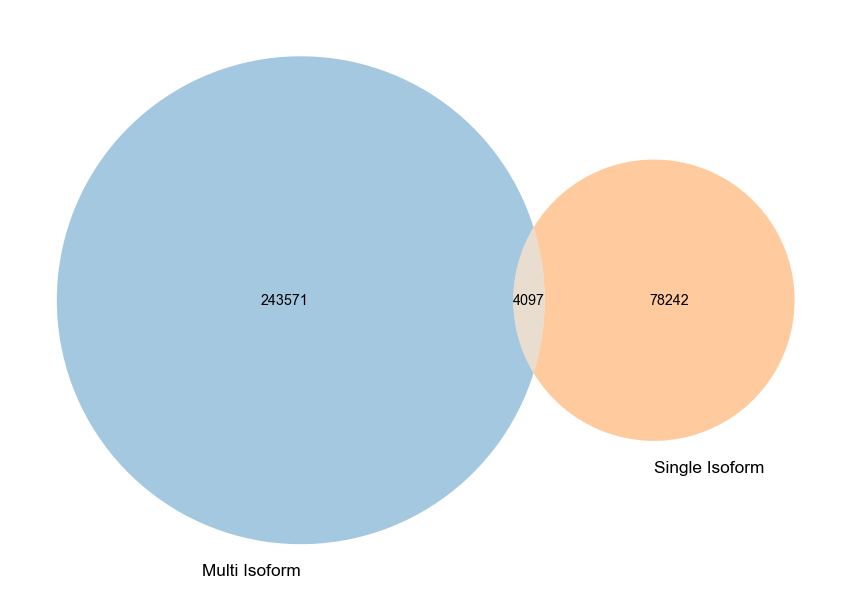

In [54]:
from matplotlib_venn import venn2
f = plt.figure(figsize=(15,15))
venn2([
    set(concat_df_sqtlseeker_dir_merge_biomart.loc[concat_df_sqtlseeker_dir_merge_biomart['Gene name'].isin(refseq.loc[refseq['Gene_type'] == 'Multi Isoform', 'Gene name'].unique().tolist())]['snpId'].unique().tolist()),
    set(concat_df_sqtlseeker_dir_merge_biomart.loc[concat_df_sqtlseeker_dir_merge_biomart['Gene name'].isin(refseq.loc[refseq['Gene_type'] == 'Single Isoform', 'Gene name'].unique().tolist())]['snpId'].unique().tolist()),
],
    ('Multi Isoform', 'Single Isoform'),  set_colors=sns.color_palette()
    )

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.154e-07 U_stat=6.873e+06


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2e643d7810>,
 [<statannot.StatResult.StatResult at 0x7f2e948adb50>])

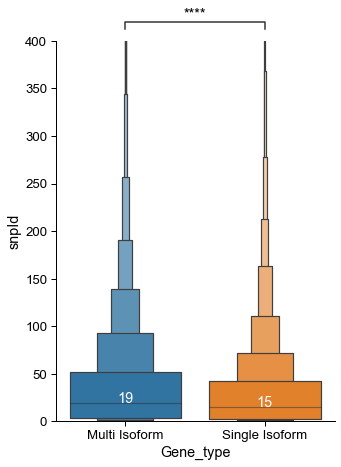

In [55]:
data = concat_df_sqtlseeker_dir_merge_biomart
data = data[['Gene_type', 'Gene name', 'snpId']].drop_duplicates().groupby(['Gene_type', 'Gene name']).count().reset_index()
data

groupby = ""
x = "Gene_type"
y = "snpId"
x_order = ['Single Isoform', 'Multi Isoform']

sns.set_context('paper', font_scale=1.5)
f, ax = plt.subplots(figsize=(5,7))
data = data.sort_values(by=x, ascending=True)
b = sns.boxenplot(data=data, x=x, y=y, ax=ax, showfliers=False)
b.set_ylim(0,400)

ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)

medians = data[[x, y]].groupby([x])[y].median().sort_index(ascending=True)
vertical_offset = data[y].median() * 0.05 # offset from median for display


for j, xtick in enumerate(b.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color=color,weight='semibold')
    
add_stat_annotation(b, data=data, x=x, y=y, order= x_order,
                    box_pairs=[tuple(x_order)],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
# data.pivot(columns='Gene_type', values='snpId').describe().style.highlight_max(color='#F39B7FFF', axis=1)

# BIOMART Genes

In [28]:
biomart_gb_gene = pd.read_csv('/gstock/EXOTIC/data/OTHERS/biomart_mi_si.csv.gz', compression='gzip', sep='\t')
biomart_gb_gene

,Gene stable ID,Transcript_count,Gene_type
0,ENSG00000000003,3,Multi Isoform
1,ENSG00000000005,1,Single Isoform
2,ENSG00000000419,4,Multi Isoform
3,ENSG00000000457,4,Multi Isoform
4,ENSG00000000460,5,Multi Isoform
...,...,...,...
22487,ENSG00000288677,1,Single Isoform
22488,ENSG00000288678,1,Single Isoform
22489,ENSG00000288681,1,Single Isoform
22490,ENSG00000288684,2,Multi Isoform


## SI genes BIOMART GRCh38

In [53]:
biomart_si_genes = biomart_gb_gene.loc[biomart_gb_gene['Gene_type'] == 'Single Isoform', 'Gene stable ID'].unique().tolist()
si_sqtl_biomart = concat_df_sqtlseeker_dir_complete.loc[concat_df_sqtlseeker_dir_complete['gene_id'].isin(biomart_si_genes)]
print(si_sqtl_biomart.gene_id.nunique())
print(si_sqtl_biomart.snpId.nunique())

585
16579


## MI genes BIOMART GRCh38

In [54]:
biomart_mi_genes = biomart_gb_gene.loc[biomart_gb_gene['Gene_type'] == 'Multi Isoform', 'Gene stable ID'].unique().tolist()
mi_sqtl_biomart = concat_df_sqtlseeker_dir_complete.loc[concat_df_sqtlseeker_dir_complete['gene_id'].isin(biomart_mi_genes)]
print(mi_sqtl_biomart.gene_id.nunique())
print(mi_sqtl_biomart.snpId.nunique())

8021
313109


In [ ]:
tmp_l = list()
concat_df_sqtlseeker_dir_complete_tmp = pd.merge(concat_df_sqtlseeker_dir_complete, 
for elem in ['Single Isoform', 'Multi Isoform']:
    biomart_tmp = biomart_gb_gene.loc[biomart_gb_gene['Gene_type'] == elem, 'Gene stable ID'].unique().tolist()
    sqtl_tmp = concat_df_sqtlseeker_dir_complete.loc[concat_df_sqtlseeker_dir_complete['gene_id'].isin(biomart_tmp)]
    tmp_l.append({
        'Gene type' : elem,
        'Gene nb' : biomart_gb_gene.loc[biomart_gb_gene['Gene_type'] == elem, 'Gene stable ID'].nunique(),
        'sGenes' : sqtl_tmp.gene_id.nunique(),
        'Ratio sGenes/Total' : round(sqtl_tmp.gene_id.nunique() / biomart_gb_gene.loc[biomart_gb_gene['Gene_type'] == elem, 'Gene stable ID'].nunique(), 2),
        'sQTL' : sqtl_tmp.snpId.nunique(),
        'Ratio sQTL/sGenes' : round(sqtl_tmp.snpId.nunique() / sqtl_tmp.gene_id.nunique(), 2),
    })
    
    
pd.DataFrame(tmp_l).set_index('Gene type')

In [ ]:
concat_df_sqtlseeker_dir_complete.loc[concat_df_sqtlseeker_dir_complete['gene_id'].isin(biomart_gb_gene.loc[biomart_gb_gene['Gene_type'] == elem, 'Gene stable ID'].unique().tolist())]

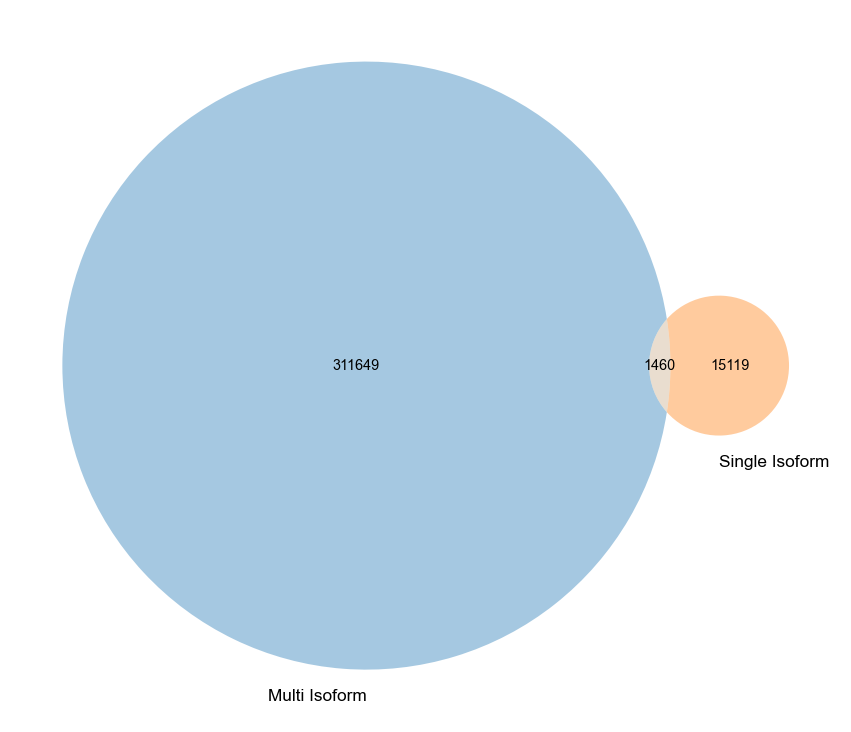

In [48]:
from matplotlib_venn import venn2
f = plt.figure(figsize=(15,15))
venn2([
    set(concat_df_sqtlseeker_dir_complete.loc[concat_df_sqtlseeker_dir_complete['gene_id'].isin(biomart_gb_gene.loc[biomart_gb_gene['Gene_type'] == 'Multi Isoform', 'Gene stable ID'].unique().tolist())]['snpId'].unique().tolist()),
    set(concat_df_sqtlseeker_dir_complete.loc[concat_df_sqtlseeker_dir_complete['gene_id'].isin(biomart_gb_gene.loc[biomart_gb_gene['Gene_type'] == 'Single Isoform', 'Gene stable ID'].unique().tolist())]['snpId'].unique().tolist()),
    
],
    ('Multi Isoform', 'Single Isoform'), set_colors=sns.color_palette()
    )

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Multi Isoform v.s. Single Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.396e-07 U_stat=2.635e+06


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2e948c5350>,
 [<statannot.StatResult.StatResult at 0x7f2e64356410>])

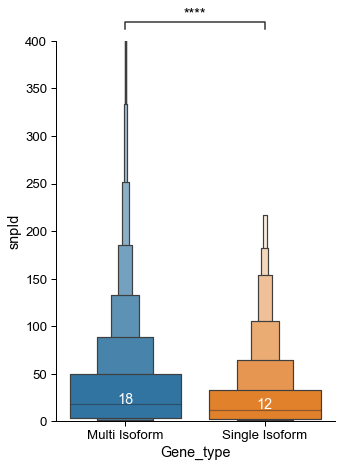

In [56]:
data = pd.merge(concat_df_sqtlseeker_dir_complete, biomart_gb_gene, left_on='gene_id', right_on='Gene stable ID')
data = data[['Gene_type', 'gene_id', 'snpId']].drop_duplicates().groupby(['Gene_type', 'gene_id']).count().reset_index()
data

groupby = ""
x = "Gene_type"
y = "snpId"
x_order = ['Multi Isoform', 'Single Isoform']

sns.set_context('paper', font_scale=1.5)
f, ax = plt.subplots(figsize=(5,7))
data = data.sort_values(by=x, ascending=True)
b = sns.boxenplot(data=data, x=x, y=y, ax=ax, showfliers=False)
b.set_ylim(0,400)

ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)

medians = data[[x, y]].groupby([x])[y].median().sort_index(ascending=True)
vertical_offset = data[y].median() * 0.05 # offset from median for display


for j, xtick in enumerate(b.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color=color,weight='semibold')
    
add_stat_annotation(b, data=data, x=x, y=y, order= x_order,
                    box_pairs=[tuple(x_order)],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
# data.pivot(columns='Gene_type', values='snpId').describe().style.highlight_max(color='#F39B7FFF', axis=1)

# All corrected Genes

In [40]:
refseq_corrected_by_gtex[['Gene', 'Gene_type']].drop_duplicates().to_csv('/gstock/EXOTIC/data/GENOMICS/single_multi_isoforms.csv', sep='\t', index=False)

In [13]:
refseq_corrected_by_gtex[['Gene', 'Gene_type']].drop_duplicates()['Gene_type'].value_counts()

Multi Isoform     8179
Single Isoform    7173
Name: Gene_type, dtype: int64

In [2]:
refseq_corrected_by_gtex = pd.read_parquet('/gstock/EXOTIC/data/GENOMICS/RefSeq_corrected_by_GTEx_lite.parquet')
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['new_mRNA_nb_total'] == 1, 'Gene_type'] = 'Single Isoform'
refseq_corrected_by_gtex.loc[refseq_corrected_by_gtex['new_mRNA_nb_total'] > 1, 'Gene_type'] = 'Multi Isoform'

biomart = pd.read_csv('/gstock/EXOTIC/data/OTHERS/biomart_refseq_ensembl_hgnc.txt.gz', compression='gzip', sep='\t')

merge_biomart = pd.merge(refseq_corrected_by_gtex[['Gene', 'Gene_type']].drop_duplicates(), biomart[['Gene stable ID', 'Gene name', 'Gene end (bp)', 'Gene start (bp)', 'Gene type']].drop_duplicates(), left_on='Gene', right_on='Gene name')

merge_biomart

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Gene,Gene_type,Gene stable ID,Gene name,Gene end (bp),Gene start (bp),Gene type
0,A2M,Multi Isoform,ENSG00000175899,A2M,9116229,9067664,protein_coding
1,A2ML1,Multi Isoform,ENSG00000166535,A2ML1,8887001,8822621,protein_coding
2,A4GALT,Single Isoform,ENSG00000128274,A4GALT,42721298,42692121,protein_coding
3,A4GNT,Single Isoform,ENSG00000118017,A4GNT,138132390,138123713,protein_coding
4,AAAS,Single Isoform,ENSG00000094914,AAAS,53324864,53307456,protein_coding
...,...,...,...,...,...,...,...
16810,ZYG11B,Single Isoform,ENSG00000162378,ZYG11B,52827336,52726453,protein_coding
16811,ZYX,Multi Isoform,ENSG00000285443,ZYX,143391111,143381295,protein_coding
16812,ZYX,Multi Isoform,ENSG00000159840,ZYX,143391111,143381295,protein_coding
16813,ZZEF1,Single Isoform,ENSG00000074755,ZZEF1,4143030,4004445,protein_coding


In [14]:
merge_biomart[['Gene', 'Gene_type']].drop_duplicates()['Gene_type'].value_counts()

Multi Isoform     8133
Single Isoform    7123
Name: Gene_type, dtype: int64

In [15]:
tmp_l = list()
for elem in ['Single Isoform', 'Multi Isoform']:
    biomart_tmp = merge_biomart.loc[merge_biomart['Gene_type'] == elem, 'Gene name'].unique().tolist()
    sqtl_tmp = concat_df_sqtlseeker_dir_all_genes_corrected.loc[concat_df_sqtlseeker_dir_all_genes_corrected['Gene name'].isin(biomart_tmp)]
    tmp_l.append({
        'Gene type' : elem,
        'Gene nb' : merge_biomart.loc[merge_biomart['Gene_type'] == elem, 'Gene name'].nunique(),
        'sGenes' : sqtl_tmp.gene_id.nunique(),
        'Ratio sGenes/Total' : round(sqtl_tmp.gene_id.nunique() / merge_biomart.loc[merge_biomart['Gene_type'] == elem, 'Gene name'].nunique(), 2),
        'sQTL' : sqtl_tmp.snpId.nunique(),
        'Ratio sQTL/sGenes' : round(sqtl_tmp.snpId.nunique() / sqtl_tmp.gene_id.nunique(), 2),
    })
    
    
pd.DataFrame(tmp_l).set_index('Gene type')

,Gene nb,sGenes,Ratio sGenes/Total,sQTL,Ratio sQTL/sGenes
Gene type,,,,,
Single Isoform,7123,2832,0.40,101728,35.92
Multi Isoform,8133,5027,0.62,206411,41.06


In [25]:
concat_df_sqtlseeker_dir_all_genes_corrected[['Gene name', 'Gene_type']].drop_duplicates()['Gene_type'].value_counts()

Multi Isoform     5026
Single Isoform    2832
Name: Gene_type, dtype: int64

In [29]:
concat_df_sqtlseeker_dir_all_genes_corrected[['snpId', 'Gene_type']].drop_duplicates()['Gene_type'].value_counts()

Multi Isoform     206411
Single Isoform    101728
Name: Gene_type, dtype: int64

In [46]:
merge_biomart.loc[(merge_biomart['Gene_type'] == 'Single Isoform'), 'Gene'].nunique()

7123

In [45]:

si_genes_sqtl = concat_df_sqtlseeker_dir_all_genes_corrected.loc[concat_df_sqtlseeker_dir_all_genes_corrected['Gene_type'] == 'Single Isoform', 'Gene'].unique().tolist()
si_genes_not_sqtl = merge_biomart.loc[(merge_biomart['Gene_type'] == 'Single Isoform') & (~merge_biomart['Gene'].isin(si_genes_sqtl)), 'Gene'].unique().tolist()
print(len(si_genes_not_sqtl))


4291

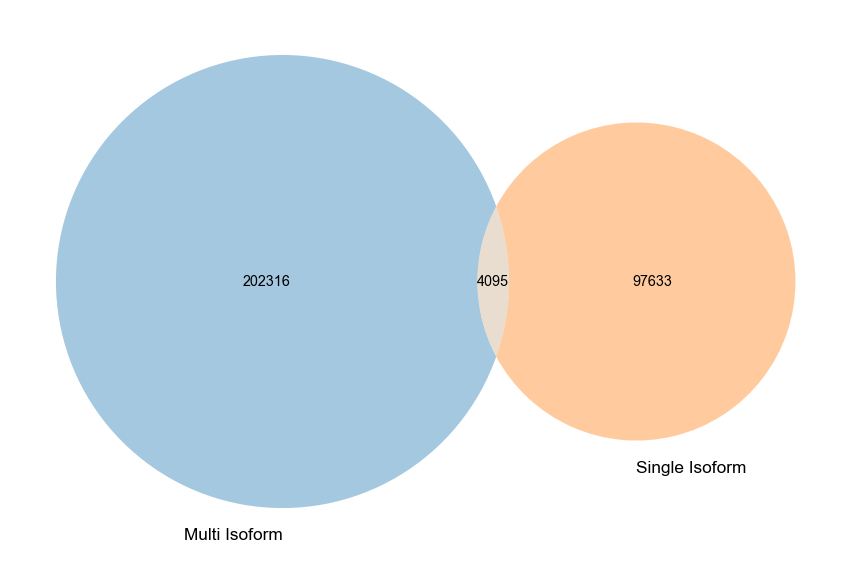

In [57]:
f = plt.figure(figsize=(15,15))

from matplotlib_venn import venn2
venn2([
    set(concat_df_sqtlseeker_dir_all_genes_corrected.loc[concat_df_sqtlseeker_dir_all_genes_corrected['Gene_type'] == 'Multi Isoform', 'snpId'].unique().tolist()),
    set(concat_df_sqtlseeker_dir_all_genes_corrected.loc[concat_df_sqtlseeker_dir_all_genes_corrected['Gene_type'] == 'Single Isoform', 'snpId'].unique().tolist()),
],
    ('Multi Isoform', 'Single Isoform'), set_colors=sns.color_palette()
    )

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.874e-06 U_stat=6.666e+06


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2db1da5310>,
 [<statannot.StatResult.StatResult at 0x7f2e642e6790>])

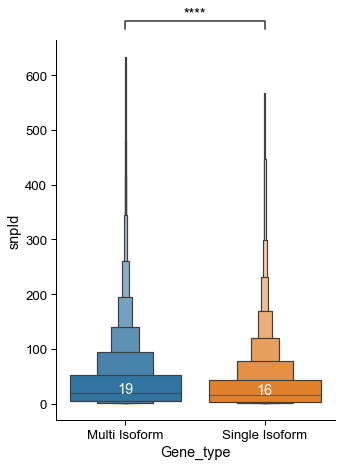

In [58]:
data = concat_df_sqtlseeker_dir_all_genes_corrected
data = data[['Gene_type', 'Gene name', 'snpId']].drop_duplicates().groupby(['Gene_type', 'Gene name']).count().reset_index()
data

groupby = ""
x = "Gene_type"
y = "snpId"
x_order = ['Single Isoform', 'Multi Isoform']

sns.set_context('paper', font_scale=1.5)
f, ax = plt.subplots(figsize=(5,7))
data = data.sort_values(by=x, ascending=True)
b = sns.boxenplot(data=data, x=x, y=y, ax=ax, showfliers=False)
# b.set_ylim(0,500000)

ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)

medians = data[[x, y]].groupby([x])[y].median().sort_index(ascending=True)
vertical_offset = data[y].median() * 0.05 # offset from median for display


for j, xtick in enumerate(b.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color=color,weight='semibold')
    
add_stat_annotation(b, data=data, x=x, y=y, order= x_order,
                    box_pairs=[tuple(x_order)],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
# data.pivot(columns='Gene_type', values='snpId').describe().style.highlight_max(color='#F39B7FFF', axis=1)

In [42]:
concat_df_sqtlseeker_dir_all_genes_corrected[['snpId']].nunique()

snpId    304044
dtype: int64

In [30]:
t = concat_df_sqtlseeker_dir_all_genes_corrected[['snpId', 'Gene_type', 'Tissue']].drop_duplicates()[['Gene_type', 'snpId']].value_counts().reset_index()
t

,Gene_type,snpId,0
0,Single Isoform,12_103947237_T_C_b38,49
1,Single Isoform,16_89502105_G_C_b38,49
2,Single Isoform,16_89504227_T_C_b38,49
3,Multi Isoform,17_5419949_C_T_b38,49
4,Multi Isoform,17_5419886_T_G_b38,49
...,...,...,...
308134,Multi Isoform,9_15943933_G_A_b38,1
308135,Multi Isoform,9_15943631_A_G_b38,1
308136,Multi Isoform,19_58406208_G_A_b38,1
308137,Multi Isoform,9_15943601_C_T_b38,1


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Single Isoform v.s. Multi Isoform: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=9.624e+09


Gene_type,Multi Isoform,Single Isoform
count,206411.000000,101728.000000
mean,7.907854,6.657184
std,10.195329,9.277772
min,1.000000,1.000000
25%,1.000000,1.000000
50%,3.000000,2.000000
75%,11.000000,8.000000
max,49.000000,49.000000


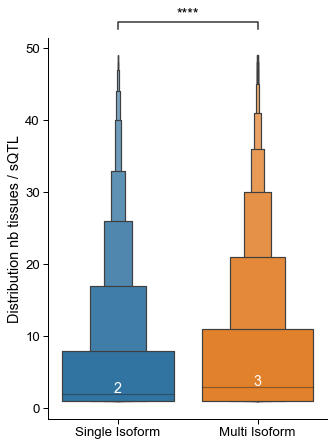

In [7]:
t = concat_df_sqtlseeker_dir_all_genes_corrected[['snpId', 'Gene_type', 'Tissue']].drop_duplicates()[['Gene_type', 'snpId']].value_counts().reset_index()

data = t

groupby = ""
x = "Gene_type"
y = 0
x_order = ['Single Isoform', 'Multi Isoform']

sns.set_context('paper', font_scale=1.5)
f, ax = plt.subplots(figsize=(5,7))
data = data.sort_values(by=x, ascending=False)
b = sns.boxenplot(data=data, x=x, y=y, ax=ax, showfliers=False)
# b.set_ylim(0,500000)

b.set_xlabel('')
b.set_ylabel('Distribution nb tissues / sQTL')

ax.spines['right'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)

medians = data[[x, y]].groupby([x])[y].median().sort_index(ascending=False)
vertical_offset = data[y].median() * 0.05 # offset from median for display


for j, xtick in enumerate(b.get_xticks()):
    if j <0:
        color='grey'
    else:
        color='w'
    b.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color=color,weight='semibold')
    
add_stat_annotation(b, data=data, x=x, y=y, order= x_order,
                    box_pairs=[tuple(x_order)],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
data.pivot(columns=x, values=y).describe().style.highlight_max(color='#F39B7FFF', axis=1)

[Text(0, 0, 'Thyroid'),
 Text(0, 0, 'Adipose - Subcutaneous'),
 Text(0, 0, 'Nerve - Tibial'),
 Text(0, 0, 'Skin - Sun Exposed (Lower leg)'),
 Text(0, 0, 'Artery - Tibial'),
 Text(0, 0, 'Testis'),
 Text(0, 0, 'Lung'),
 Text(0, 0, 'Skin - Not Sun Exposed (Suprapubic)'),
 Text(0, 0, 'Muscle - Skeletal'),
 Text(0, 0, 'Esophagus - Muscularis'),
 Text(0, 0, 'Adipose - Visceral (Omentum)'),
 Text(0, 0, 'Cells - Cultured fibroblasts'),
 Text(0, 0, 'Breast - Mammary Tissue'),
 Text(0, 0, 'Esophagus - Mucosa'),
 Text(0, 0, 'Artery - Aorta'),
 Text(0, 0, 'Esophagus - Gastroesophageal Junction'),
 Text(0, 0, 'Colon - Transverse'),
 Text(0, 0, 'Colon - Sigmoid'),
 Text(0, 0, 'Heart - Atrial Appendage'),
 Text(0, 0, 'Pituitary'),
 Text(0, 0, 'Spleen'),
 Text(0, 0, 'Stomach'),
 Text(0, 0, 'Whole Blood'),
 Text(0, 0, 'Heart - Left Ventricle'),
 Text(0, 0, 'Brain - Cerebellum'),
 Text(0, 0, 'Adrenal Gland'),
 Text(0, 0, 'Pancreas'),
 Text(0, 0, 'Prostate'),
 Text(0, 0, 'Artery - Coronary'),
 Text(0, 0,

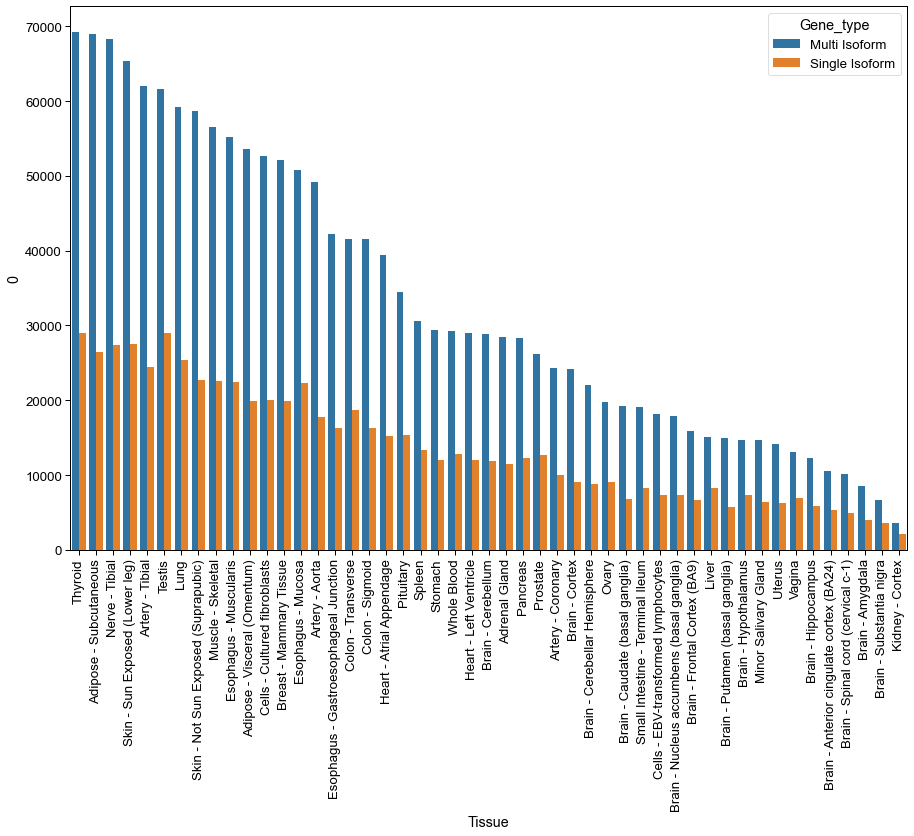

In [41]:
t = concat_df_sqtlseeker_dir_all_genes_corrected[['snpId', 'Gene_type', 'Tissue']].drop_duplicates()[['Gene_type', 'Tissue']].value_counts().reset_index()

f, ax = plt.subplots(figsize=(15,10))
s = sns.barplot(data=t, x='Tissue', y=0, hue='Gene_type')
s.set_xticklabels(s.get_xticklabels(), rotation=90)